In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pandas as pd
from sklearn.mixture import GaussianMixture


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-05-24 11:43:33.379126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 11:43:35.832482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-24 11:43:35.832557: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-24 11:43:42.927713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

In [52]:
gen_batch_train,gen_batch_val = get_generators(typ,0,100,BATCH_SIZE = 5,known_variance=True)

In [53]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

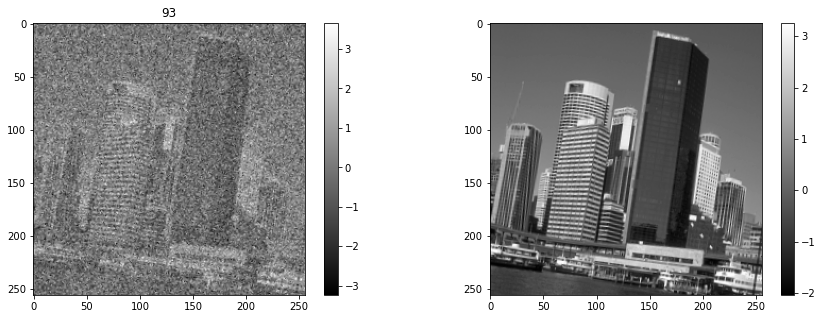

In [54]:
_ = np.random.choice(len(xs['input']))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(xs['input'][_],cmap='gray')
plt.title(xs['var'][_][0])
plt.colorbar()
plt.subplot(122)
plt.imshow(ys[_],cmap='gray')
plt.colorbar()
plt.show()

In [55]:
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256,latent_size=1024):
    
    
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(latent_size, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return x

In [56]:
class function_type:
    def splines(y,num_classes,order):


        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)

        a = tf.keras.layers.Reshape((num_classes,order))(a)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)

        return a,b

    def decreasing(y,num_classes,order):
        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)
        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        a = tf.keras.layers.Lambda(lambda z:-tf.math.pow(z,2))(a)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)

        return a,b

    def flux(y,num_classes,order):
        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        #s0 = tf.keras.layers.Dense(1,activation='sigmoid')(y)
        s0 = tf.keras.layers.Lambda(lambda z: 0.5*tf.ones_like(z))(b_initial)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s0))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)


        minimum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s0,minimum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s0,a))
        fun = tf.keras.layers.add((coeffs,fun))
        minimum = tf.keras.layers.Lambda(lambda z:-tf.reduce_min(z[...,0],axis=-1))(fun)
        minimum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.less_equal(-z,0),dtype=tf.float32))(minimum)
        minimum = tf.keras.layers.multiply((minimum,minimum_neg))

        b = tf.keras.layers.add((b,minimum))

        a_pos,b_pos = a,b

        b_middle = tf.keras.layers.Dense(1,activation='linear')(y)
        b_middle = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_middle)


        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        s1 = tf.keras.layers.Lambda(lambda z: tf.ones_like(z)-z)(s0)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s1))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_middle))
        b = tf.expand_dims(b,axis=-1)


        maximum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s1,maximum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s1))
        coeffs = tf.keras.layers.add((coeffs,s0))
        coeffs = tf.keras.layers.multiply((a,coeffs))
        fun = tf.keras.layers.add((coeffs,fun))
        maximum = tf.keras.layers.Lambda(lambda z:-tf.reduce_max(z[...,0],axis=-1))(fun)
        maximum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.greater_equal(-z,0),dtype=tf.float32))(maximum)
        maximum = tf.keras.layers.multiply((maximum,maximum_neg))
        maximum = tf.keras.layers.Lambda(lambda z:tf.expand_dims(z,axis=-1))(maximum)

        b = tf.keras.layers.add((b,maximum))

        a_neg,b_neg = a,b

        a = tf.keras.layers.Concatenate(axis=1)((a_pos,a_neg))
        b = tf.keras.layers.Concatenate(axis=1)((b_pos,b_neg))

        return a,b
    
    def fluxdecreasing(y,num_classes,order):
        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        a = tf.keras.layers.Lambda(lambda z:-tf.math.pow(z,2))(a)
        s0 = tf.keras.layers.Lambda(lambda z: 0.5*tf.ones_like(z))(b_initial)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s0))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)


        minimum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s0,minimum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s0,a))
        fun = tf.keras.layers.add((coeffs,fun))
        minimum = tf.keras.layers.Lambda(lambda z:-tf.reduce_min(z[...,0],axis=-1))(fun)
        minimum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.less_equal(-z,0),dtype=tf.float32))(minimum)
        minimum = tf.keras.layers.multiply((minimum,minimum_neg))

        b = tf.keras.layers.add((b,minimum))

        a_pos,b_pos = a,b

        b_middle = tf.keras.layers.Dense(1,activation='linear')(y)
        b_middle = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_middle)


        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        a = tf.keras.layers.Lambda(lambda z:-tf.math.pow(z,2))(a)
        s1 = tf.keras.layers.Lambda(lambda z: tf.ones_like(z)-z)(s0)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s1))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_middle))
        b = tf.expand_dims(b,axis=-1)


        maximum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s1,maximum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s1))
        coeffs = tf.keras.layers.add((coeffs,s0))
        coeffs = tf.keras.layers.multiply((a,coeffs))
        fun = tf.keras.layers.add((coeffs,fun))
        maximum = tf.keras.layers.Lambda(lambda z:-tf.reduce_max(z[...,0],axis=-1))(fun)
        maximum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.greater_equal(-z,0),dtype=tf.float32))(maximum)
        maximum = tf.keras.layers.multiply((maximum,maximum_neg))
        maximum = tf.keras.layers.Lambda(lambda z:tf.expand_dims(z,axis=-1))(maximum)

        b = tf.keras.layers.add((b,maximum))

        a_neg,b_neg = a,b

        a = tf.keras.layers.Concatenate(axis=1)((a_pos,a_neg))
        b = tf.keras.layers.Concatenate(axis=1)((b_pos,b_neg))

        return a,b
    
    
def constraint(W):
    or_shape = W.shape
    shift = (2*degree+2)*((2*degree+1)//2)
    NW = []
    for w in tf.unstack(W,axis=-1):
        nw = tf.roll(tf.reshape(w,[(2*degree+1)**2]),shift=shift+1,axis=0)
        nw = tf.slice(nw,[1],[(2*degree+1)**2-1])
        nw = tf.abs(nw)
        center = -tf.expand_dims(tf.reduce_sum(nw),0)
        nw = tf.concat((center,nw),axis=0)
        nw = tf.roll(nw,shift,axis=0)
        nw = tf.reshape(nw,(2*degree+1,2*degree+1,1))
        NW.append(nw)

    return tf.stack(NW,axis=-1)


def regularizer(w):

    projections = tf.unstack(w,axis=-1)
    initial = 0

    for pr in range(len(projections)):
        for ps in range(len(projections)):
            if pr > ps:
                proj = tf.multiply(projections[pr],projections[ps])
                initial += tf.reduce_sum(tf.abs(proj)) - tf.reduce_sum(tf.abs(proj[degree,degree]))
                

    
    return factor1 * initial

def differential_operator(input_shape,num_filters,polynomial_degree,typee,inputs_var=None,latent_size=None):
    
    outputs = tf.keras.Input(shape=input_shape,name='input_differential')
    
    if (typee == 'diffop') or (typee == 'nopretrained'):
        diff_op1 = tf.keras.layers.Conv2D(num_filters,(2*degree+1,2*degree+1),padding='same',use_bias=False,
                            kernel_constraint=constraint,kernel_regularizer = regularizer, name='diff')(outputs)
    if (typee != 'diffop') and (typee != 'nopretrained'):
        diff_op1 = tf.keras.layers.Conv2D(num_filters,(2*degree+1,2*degree+1),padding='same',use_bias=False,name='diff')(outputs)
    
    diff_op1 = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(diff_op1)
    
    if typee != 'foe' and typee != 'foek':
        diff_op = tf.keras.layers.Conv2D(1,1,padding='same',name='no_train',activation='sigmoid')(diff_op1)
    if typee == 'foe':
        diff_op = tf.keras.layers.Conv2D(1,1,padding='same',name='no_train')(diff_op1)
        
        if inputs_var != None:
        
            embedded = tf.keras.layers.Embedding(100,latent_size)(inputs_var)
            embedded = tf.keras.layers.Flatten()(embedded)
            embedded = tf.keras.layers.Reshape((int(np.sqrt(latent_size)),int(np.sqrt(latent_size)),1))(embedded)
            embedded = tf.keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(embedded)
            embedded = tf.keras.layers.Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(embedded)
            embedded = tf.keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), padding='same')(embedded)
            embedded = tf.keras.layers.Conv2D(1,1, padding='same')(embedded)
            diff_op = tf.keras.layers.multiply([diff_op,embedded])
        
        diff_op = tf.keras.layers.Dense(64,activation = 'relu')(diff_op)
        diff_op = tf.keras.layers.Dense(32,activation = 'relu')(diff_op)
        diff_op = tf.keras.layers.Dense(1,activation = 'relu')(diff_op)
        
    if typee == 'foek':
        diff_op = tf.keras.layers.Conv2D(1,5,padding='same',name='no_train')(diff_op1)
        
        if inputs_var != None:
        
            embedded = tf.keras.layers.Embedding(100,latent_size)(inputs_var)
            embedded = tf.keras.layers.Flatten()(embedded)
            embedded = tf.keras.layers.Reshape((int(np.sqrt(latent_size)),int(np.sqrt(latent_size)),1))(embedded)
            embedded = tf.keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(embedded)
            embedded = tf.keras.layers.Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(embedded)
            embedded = tf.keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), padding='same')(embedded)
            embedded = tf.keras.layers.Conv2D(1,1, padding='same')(embedded)
            diff_op = tf.keras.layers.multiply([diff_op,embedded])
        
        diff_op = tf.keras.layers.Dense(64,activation = 'relu')(diff_op)
        diff_op = tf.keras.layers.Dense(32,activation = 'relu')(diff_op)
        diff_op = tf.keras.layers.Dense(1,activation = 'relu')(diff_op)
        
    if inputs_var != None:

        return tf.keras.Model([outputs,inputs_var],diff_op)
    else:
        return tf.keras.Model(outputs,diff_op)



In [79]:
def get_model(arch,it_lim,image_size,typ='gaussian',num_classes=1,CROP = 256,order = 1,gamma=1,second=True,degree1=3,
             factor=1,typee='noconstraints',known_variance=True,latent_size=1024):

    global factor1
    factor1 = factor
    
    global degree
    degree = degree1


    input_shape = image_size + (1,)   
    if typee != 'classic':
        num_filters = np.sum(2**np.arange(1,degree+1))
        
        if known_variance:
            inputs_var = tf.keras.Input(shape=(1),name='var')
            if 'foe' in typee:
                differential_model = differential_operator(input_shape,num_filters,degree,typee,
                                                       inputs_var=inputs_var,latent_size=latent_size)
                
            else:
                differential_model = differential_operator(input_shape,num_filters,degree,typee)
        else:
            differential_model = differential_operator(input_shape,num_filters,degree,typee)
        
        if typee == 'diffop':
            
            location = '/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/thesis/7_apr/general/checkpoints'
        
            differential_model.load_weights(f'/{location}/DifferentialClassifier_{degree}')
            
    if (known_variance) and (typee == 'classic'):
        inputs_var = tf.keras.Input(shape=(1),name='var')


    inputs = tf.keras.Input(shape=input_shape,name='input')
    
    
    x = classifier(inputs, num_classes=num_classes,CROP=CROP,latent_size=latent_size)
    y = tf.keras.layers.Flatten(name='y')(x)
    
    if known_variance:
        embedded = tf.keras.layers.Embedding(100,latent_size)(inputs_var)
        embedded = tf.keras.layers.Flatten(name='embedded')(embedded)
        y = tf.keras.layers.Lambda(lambda z:tf.multiply(z[0],z[1]))([y,embedded])
    
    a,b = getattr(function_type,arch)(y,num_classes,order)    
    b = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.ones_like(z[0]),z[1]))([a,b])
    if 'flux' in arch:
        num_classes = 2*num_classes


    partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
    partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
    partition_low = tf.cast(partition_low,tf.float32)
    partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
    partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
    partition_up = tf.cast(partition_up,tf.float32)


    ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
    ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

    outputs = inputs


    for num_it in range(it_lim):


        if typee != 'classic':  
            if ('foe' not in typee) or (not known_variance):
                diff_op = differential_model(outputs)
            else:
                diff_op = differential_model([outputs,inputs_var])

            diff_op = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(diff_op)

        else:
            dS_n,dE_n = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
            dS = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dS_n)
            dE = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dE_n)
            diff_op = tf.keras.layers.add((dS,dE))



        ineq1 = tf.greater_equal(diff_op, partition_low)
        ineq2 = tf.less_equal(diff_op,partition_up)

        interval = tf.cast(tf.math.logical_and(ineq1,ineq2),tf.float32)

        power_norm = tf.constant(np.asarray(np.arange(1,order+1),dtype='float32'))
        power_norm = tf.keras.layers.Lambda(lambda z:tf.pow(z[0],z[1]))([diff_op,power_norm])
        cte = tf.ones_like(inputs)
        power_norm = tf.keras.layers.Concatenate(axis=-1)((cte,power_norm))
        power_norm = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm)

        spline = tf.keras.layers.multiply([ct,power_norm])
        spline = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline)
        spline = tf.keras.layers.multiply([spline,interval])

        g = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'g_{num_it}')(spline)
        g = tf.expand_dims(g,axis=-1)


        deltaS,deltaE = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
        E = tf.keras.layers.multiply((g,deltaE))
        S = tf.keras.layers.multiply((g,deltaS))

        NS = S
        EW = E
        zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
        zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
        NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
        EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
        NS = tf.keras.layers.Lambda(lambda z: z[:,1:] - z[:,:-1])(NS)
        EW = tf.keras.layers.Lambda(lambda z: z[:,:,1:] - z[:,:,:-1])(EW)

        mult = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.cast(gamma,dtype=tf.float32),z))(tf.ones_like(NS))

        adding = tf.keras.layers.add([NS,EW])
        adding = tf.keras.layers.multiply((mult,adding))

        outputs = tf.keras.layers.add([outputs,adding])
       
    
    if known_variance:
        return tf.keras.models.Model([inputs,inputs_var], outputs)
    else:
        return tf.keras.models.Model(inputs, outputs)

In [64]:
model = get_model('splines',10,image_size,num_classes=10,known_variance=True,typee='foe')

In [65]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 128, 128, 32  320         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_88 (BatchN  (None, 128, 128, 32  128        ['conv2d_55[0][0]']              
 ormalization)                  )                                                          

                                                                                                  
 separable_conv2d_77 (Separable  (None, 32, 32, 64)  4736        ['activation_95[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_95 (BatchN  (None, 32, 32, 64)  256         ['separable_conv2d_77[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 16, 16, 64)  0           ['batch_normalization_95[0][0]'] 
 )                                                                                                
                                                                                                  
 conv2d_59

                                                                                                  
 tf.compat.v1.transpose_7 (TFOp  (None, 1, 10)       0           ['multiply_220[0][0]']           
 Lambda)                                                                                          
                                                                                                  
 tf.linalg.band_part_7 (TFOpLam  (None, None, None)  0           ['tf.convert_to_tensor_7[0][0]'] 
 bda)                                                                                             
                                                                                                  
 multiply_221 (Multiply)        (None, None, 10)     0           ['tf.compat.v1.transpose_7[0][0]'
                                                                 , 'tf.linalg.band_part_7[0][0]'] 
                                                                                                  
 lambda_38

                                )                                                                 
                                                                                                  
 tf.cast_40 (TFOpLambda)        (None, 256, 256, 10  0           ['tf.math.logical_and_40[0][0]'] 
                                )                                                                 
                                                                                                  
 multiply_223 (Multiply)        (None, 256, 256, 10  0           ['lambda_397[0][0]',             
                                )                                 'tf.cast_40[0][0]']             
                                                                                                  
 tf.zeros_like_81 (TFOpLambda)  (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 g_0 (Lamb

                                                                                                  
 tf.math.logical_and_41 (TFOpLa  (None, 256, 256, 10  0          ['tf.math.greater_equal_41[0][0]'
 mbda)                          )                                , 'tf.math.less_equal_41[0][0]'] 
                                                                                                  
 lambda_405 (Lambda)            (None, 256, 256, 10  0           ['multiply_227[0][0]']           
                                )                                                                 
                                                                                                  
 tf.cast_41 (TFOpLambda)        (None, 256, 256, 10  0           ['tf.math.logical_and_41[0][0]'] 
                                )                                                                 
                                                                                                  
 multiply_

 tf.math.less_equal_42 (TFOpLam  (None, 256, 256, 10  0          ['lambda_410[0][0]']             
 bda)                           )                                                                 
                                                                                                  
 multiply_232 (Multiply)        (None, 256, 256, 10  0           ['lambda_393[0][0]',             
                                , 2)                              'lambda_412[0][0]']             
                                                                                                  
 tf.math.logical_and_42 (TFOpLa  (None, 256, 256, 10  0          ['tf.math.greater_equal_42[0][0]'
 mbda)                          )                                , 'tf.math.less_equal_42[0][0]'] 
                                                                                                  
 lambda_413 (Lambda)            (None, 256, 256, 10  0           ['multiply_232[0][0]']           
          

                                 2)                                                               
                                                                                                  
 tf.math.greater_equal_43 (TFOp  (None, 256, 256, 10  0          ['lambda_418[0][0]']             
 Lambda)                        )                                                                 
                                                                                                  
 tf.math.less_equal_43 (TFOpLam  (None, 256, 256, 10  0          ['lambda_418[0][0]']             
 bda)                           )                                                                 
                                                                                                  
 multiply_237 (Multiply)        (None, 256, 256, 10  0           ['lambda_393[0][0]',             
                                , 2)                              'lambda_420[0][0]']             
          

                                                                                                  
 concatenate_140 (Concatenate)  (None, 256, 256, 2)  0           ['tf.ones_like_88[0][0]',        
                                                                  'lambda_427[0][0]']             
                                                                                                  
 lambda_428 (Lambda)            (None, 256, 256, 1,  0           ['concatenate_140[0][0]']        
                                 2)                                                               
                                                                                                  
 tf.math.greater_equal_44 (TFOp  (None, 256, 256, 10  0          ['lambda_426[0][0]']             
 Lambda)                        )                                                                 
                                                                                                  
 tf.math.l

 lambda_434 (Lambda)            (None, 256, 256, 1)  0           ['model_13[5][0]']               
                                                                                                  
 tf.ones_like_90 (TFOpLambda)   (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 lambda_435 (Lambda)            (None, 256, 256, 1)  0           ['lambda_434[0][0]']             
                                                                                                  
 concatenate_143 (Concatenate)  (None, 256, 256, 2)  0           ['tf.ones_like_90[0][0]',        
                                                                  'lambda_435[0][0]']             
                                                                                                  
 lambda_436 (Lambda)            (None, 256, 256, 1,  0           ['concatenate_143[0][0]']        
          

                                                                  'add_134[0][0]']                
                                                                                                  
 add_135 (Add)                  (None, 256, 256, 1)  0           ['add_133[0][0]',                
                                                                  'multiply_251[0][0]']           
                                                                                                  
 lambda_442 (Lambda)            (None, 256, 256, 1)  0           ['model_13[6][0]']               
                                                                                                  
 tf.ones_like_92 (TFOpLambda)   (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 lambda_443 (Lambda)            (None, 256, 256, 1)  0           ['lambda_442[0][0]']             
          

                                                                                                  
 add_136 (Add)                  (None, 256, 256, 1)  0           ['lambda_447[0][0]',             
                                                                  'lambda_448[0][0]']             
                                                                                                  
 multiply_256 (Multiply)        (None, 256, 256, 1)  0           ['lambda_449[0][0]',             
                                                                  'add_136[0][0]']                
                                                                                                  
 add_137 (Add)                  (None, 256, 256, 1)  0           ['add_135[0][0]',                
                                                                  'multiply_256[0][0]']           
                                                                                                  
 lambda_45

 tf.ones_like_95 (TFOpLambda)   (None, 256, 256, 1)  0           ['lambda_455[0][0]']             
                                                                                                  
 lambda_456 (Lambda)            (None, 256, 256, 1)  0           ['concatenate_151[0][0]']        
                                                                                                  
 lambda_457 (Lambda)            (None, 256, 256, 1)  0           ['tf.ones_like_95[0][0]']        
                                                                                                  
 add_138 (Add)                  (None, 256, 256, 1)  0           ['lambda_455[0][0]',             
                                                                  'lambda_456[0][0]']             
                                                                                                  
 multiply_261 (Multiply)        (None, 256, 256, 1)  0           ['lambda_457[0][0]',             
          

 lambda_463 (Lambda)            (None, 256, 256, 1)  0           ['concatenate_153[0][0]']        
                                                                                                  
 concatenate_154 (Concatenate)  (None, 256, 257, 1)  0           ['tf.expand_dims_153[0][0]',     
                                                                  'multiply_264[0][0]']           
                                                                                                  
 tf.ones_like_97 (TFOpLambda)   (None, 256, 256, 1)  0           ['lambda_463[0][0]']             
                                                                                                  
 lambda_464 (Lambda)            (None, 256, 256, 1)  0           ['concatenate_154[0][0]']        
                                                                                                  
 lambda_465 (Lambda)            (None, 256, 256, 1)  0           ['tf.ones_like_97[0][0]']        
          

 )                                                               [0]']                            
                                                                                                  
 multiply_269 (Multiply)        (None, 256, 256, 1)  0           ['tf.expand_dims_155[0][0]',     
                                                                  'lambda_470[0][1]']             
                                                                                                  
 lambda_471 (Lambda)            (None, 256, 256, 1)  0           ['concatenate_156[0][0]']        
                                                                                                  
 concatenate_157 (Concatenate)  (None, 256, 257, 1)  0           ['tf.expand_dims_156[0][0]',     
                                                                  'multiply_269[0][0]']           
                                                                                                  
 tf.ones_l

In [80]:
for known_variance in [False,True]:
    
    gen_batch_train,gen_batch_val = get_generators(typ,0,100,BATCH_SIZE = 5,known_variance=known_variance)
    
    xs, ys = next(gen_batch_val.as_numpy_iterator())
    for typee in ['classic','noconstraints','foe','foek']:
        print(known_variance,typee)
        model = get_model('splines',10,image_size,num_classes=10,known_variance=known_variance,typee=typee)
        p = model(xs)

False classic
False noconstraints
False foe
False foek
True classic
True noconstraints
True foe
True foek


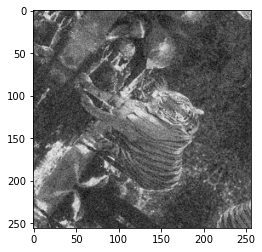

In [84]:
plt.imshow(p[0],cmap='gray')